# 1 Constructing the matrix X

In [118]:
import numpy as np
import scipy
from scipy.sparse import coo_matrix

def construct_X(M, alphas, Np=None):
    # Total number of pixels in the tomogram
    D = M * M  
    # Number of projection angles
    No = len(alphas)  
    
    if Np is None:
        # Default sensor resolution
        Np = int(np.ceil(np.sqrt(2) * M))  
    # Total number of sensor elements
    N = No * Np  

    h = 1  # Pixel distance
    
    # Define the coordinates of the tomogram's pixel centers
    a0 = -(M-1) / 2
    b0 = -(M-1) / 2
    ja, jb = np.mgrid[0:M, 0:M].reshape(2, -1)
    C0, C1 = [], []

    for i in range(0, M*M):
        C0.append(a0 + ja[i] * h)
        C1.append(b0 + jb[i] * h)
    C = np.array([C0, np.flip(C1,0)])

    X_entries = []
    i_indices = []
    j_indices = []
    
    for io, alpha in enumerate(alphas):
        # Convert angle to radians
        alpha_rad = np.radians(alpha)  

        # Compute the current orientation as a unit vector
        n = np.array([np.cos(alpha_rad), np.sin(alpha_rad)])

        # Compute the projection of each pixel onto the sensor
        # Distance between the first sensor element and the coordinate origin
        s0 = (Np - 1) / 2  
        p = np.dot(n.T, C) + s0
        
        # Compute the weights for each pixel
        # Sensor element indices
        ip = np.floor(p).astype(int)
        ip_add = ip + 1
        rest_intensity = p - ip  
        weights = np.array([1 - rest_intensity, rest_intensity])
        
        # Keep track of the non-zero entries of X
        valid_indices = np.where((ip < Np))[0]
        valid_ip = ip[valid_indices]
        valid_j = ja[valid_indices] + M * jb[valid_indices]
        valid_weights = weights[0,:][valid_indices]
        for w in valid_weights:
            X_entries.append(w)
        i_indices.extend(valid_ip + Np * io)
        j_indices.extend(valid_j)

        valid_indices = np.where((ip_add < Np))[0]
        valid_ip_add = ip_add[valid_indices]
        valid_j = ja[valid_indices] + M * jb[valid_indices]
        valid_weights = weights[1,:][valid_indices]
        for w in valid_weights:
            X_entries.append(w)
        i_indices.extend(valid_ip_add + Np * io)
        j_indices.extend(valid_j)

    X = coo_matrix((X_entries, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)

    return X


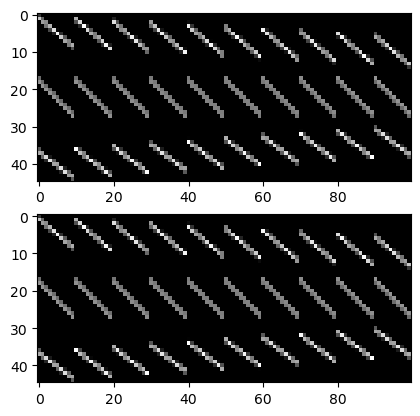

In [138]:
import matplotlib.pyplot as plt

# Example usage
M = 10
alphas = [-33, 1, 42]
X = construct_X(M, alphas, 15)

# Convert sparse matrix to a dense numpy array for visualization
X_dense = X.toarray()

# load sample solution
X_ex = np.load('hs_tomography/X_example.npy')

fig, axs = plt.subplots(2, 1)
axs[0].imshow(X_dense, cmap='gray')
axs[1].imshow(X_ex, cmap='gray')
plt.show()

# 2 Recovering the image

In [165]:
import numpy as np
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

def display_x_ray(alphas, y, M, Np, title="Reconstructed Tomogram"):

    # Construct X matrix
    X = construct_X(M=M, alphas=alphas, Np=Np)

    # Find the least-squares solution using lsqr solver
    # Convert X to sparse matrix
    X_sparse = scipy.sparse.csc_matrix(X) 
    # Tolerance for the solver 
    tol = 1e-05  
    beta, _ = linalg.lsqr(X_sparse, y, atol=tol, btol=tol)[:2]

    # Reshape beta to a 2D array based on the desired image dimensions
    # Specify the desired image width (number of columns)
    image_width = M  
    # Calculate the corresponding image height (number of rows)
    image_height = len(beta) // image_width  
    image = np.reshape(beta, (image_height, image_width))

    # Plot the image
    # Use a grayscale colormap
    plt.imshow(image, cmap='gray')  
    plt.title(title)
    # Add a colorbar for reference
    plt.colorbar()  
    plt.show()


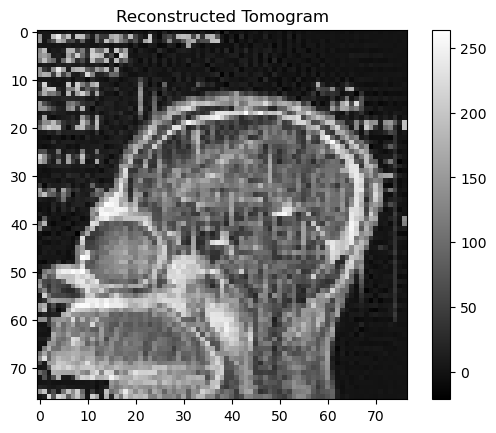

In [166]:
# Load the data
alphas = np.load('hs_tomography/alphas_77.npy')
y = np.load('hs_tomography/y_77.npy')

display_x_ray(alphas=alphas, y=y, M=77, Np=109)

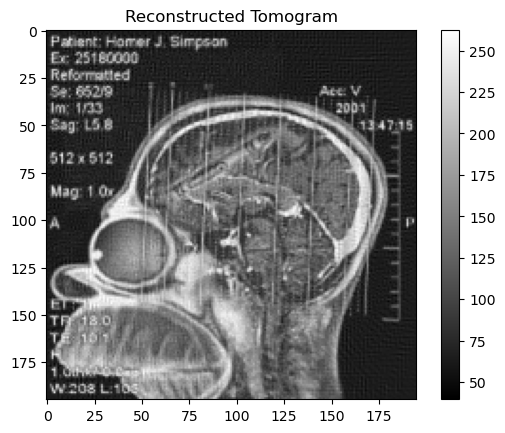

In [167]:
# Load the data
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')

display_x_ray(alphas=alphas, y=y, M=195, Np=275)

# 3 Minimizing the radiation dose

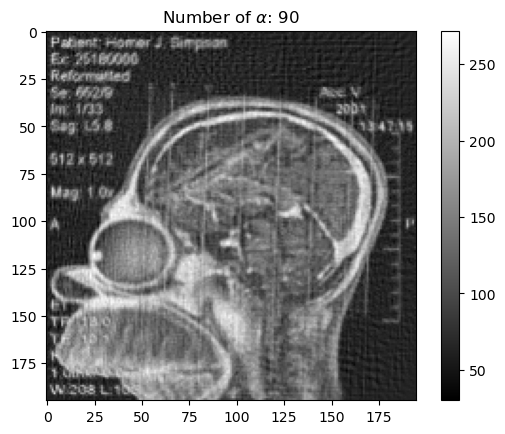

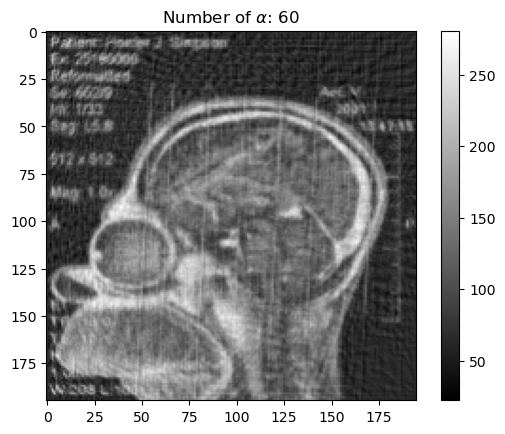

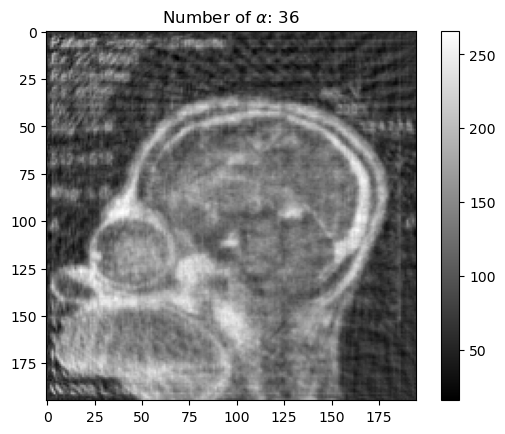

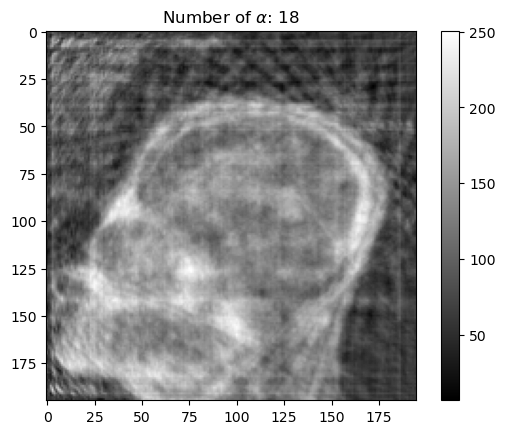

In [169]:
# Load the data
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')

modulo_factors = [2, 3, 5, 10]
#fig, axs = plt.subplots(1, 4)

for factor in modulo_factors:
    # filter angles with modulo
    filter = alphas % factor == 0
    alphas_reduced = alphas[filter]
    y_filtered = y.reshape(179, 275)[filter, :].flatten()

    title = r"Number of $\alpha$: " + str(len(alphas_reduced))
    display_x_ray(alphas=alphas_reduced, y=y_filtered, M=195, Np=275, title=title)

You can reduce the number of angles to 60 and still see that a crayon caused Homers headache.